In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# ======================
# DATA CLEANING
# ======================

# FISH DETAILS

In [2]:
dtypes = {
    'YEAR': 'Int32', 
    'MM': 'Int32', 
    'DD': 'Int32', 
    'WEEK': 'Int32', 
    'SITE': 'object', 
    'PERIOD': 'object', 
    'CONDITION': 'object', 
    'FISH_NO': 'Int32', 
    'FL_WET': 'Int32', 
    'FL_FROZEN': 'object',  # error: Unable to parse string " ", covert to numeric manually
    'FL_STD': 'float64',
    'WEIGHT': 'float64',
    'SPECIES': 'object', 
    'SEX': 'object', 
    'MATURITY': 'object',  # error: Unable to parse string " ", covert to numeric manually
    'GONAD_WEIGHT': 'object',  # error: Unable to parse string " ", covert to numeric manually
    '1st Person Aging': 'object',  # error: could not convert string to float: ''
    'AGE': 'object',  # error: Unable to parse string "No Slide", covert to numeric manually
    'FSP': 'object',  # error: Unable to parse string " ", covert to numeric manually
    'Comments': 'object', 
    '2nd Person Aging': 'object', 
    'AGE.1': 'object',  # error: Unable to parse string ".", covert to numeric manually
    'FSP.1': 'object',  # error: Unable to parse string ".", covert to numeric manually
    'Comments.1': 'object', 
    'Envelop Comments': 'object'
} 

# initial data import
df_FD = pd.read_csv('csv_MASTER_Gaspereau_details_Larry.csv', dtype=dtypes)

# create backup of notes (including all numeric data for simplicity)
df_FD['AGE_notes'] = df_FD['AGE']
df_FD['FSP_notes'] = df_FD['FSP']

# convert to numeric and coerce errors (all non-numeric data converted to null)
df_FD['FL_FROZEN'] = pd.to_numeric(df_FD['FL_FROZEN'], errors='coerce').astype('Int32')
df_FD['MATURITY'] = pd.to_numeric(df_FD['MATURITY'], errors='coerce').astype('Int32')
df_FD['GONAD_WEIGHT'] = pd.to_numeric(df_FD['GONAD_WEIGHT'], errors='coerce')  # float
df_FD['AGE'] = pd.to_numeric(df_FD['AGE'], errors='coerce').astype('Int32')
df_FD['FSP'] = pd.to_numeric(df_FD['FSP'], errors='coerce').astype('Int32')
df_FD['AGE.1'] = pd.to_numeric(df_FD['AGE.1'], errors='coerce').astype('Int32')
df_FD['FSP.1'] = pd.to_numeric(df_FD['FSP.1'], errors='coerce').astype('Int32')

# add a DATETIME column
df_FD['DATETIME'] = pd.to_datetime(df_FD['YEAR'].astype(str) + '-' + df_FD['MM'].astype(str) + '-' + df_FD['DD'].astype(str))

### Cleaning categorical data

In [3]:
df_FD.loc[df_FD.PERIOD == 'PM ', 'PERIOD'] = 'PM'
df_FD.loc[df_FD.CONDITION == 'FROZEN', 'CONDITION'] = 'Frozen'
df_FD.loc[df_FD.CONDITION == 'FRESH', 'CONDITION'] = 'Fresh'

### PERIOD: convert 'AD' to 'AM' - CONFIRM
* (118 entries)
* Other CSV also include AD periods for entered data

In [4]:
confirm_AD_to_AM = False

if confirm_AD_to_AM:
    df_FD.loc[df_FD.PERIOD == 'AD', 'PERIOD'] = 'AM'

### Q: What is happening with the latest data (drops in weight etc)?

##### data input issues?
* in 2016, there were order of magnitude difference betwwen FL_STD:
  * look to be 10x smaller
  * from row 34989 to row 35187
* similarly, month 6, there were five strange entries for FL_WET and FL_FROZEN
  * row 35058 (~100x smaller)
  * 35143 (~10x smaller)
  * 35157 (~100x smaller)
  * 35158 (~100x smaller)
  * 35186 (~100x smaller)
  * These are largely influencing the average because they are a different order of magnitude


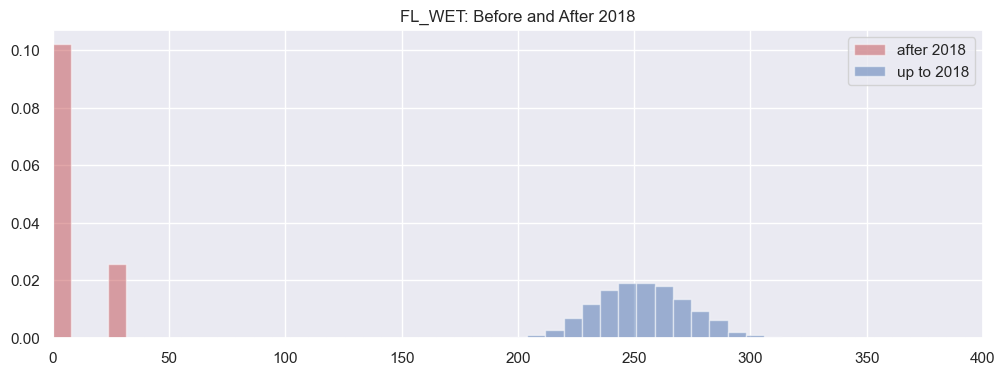

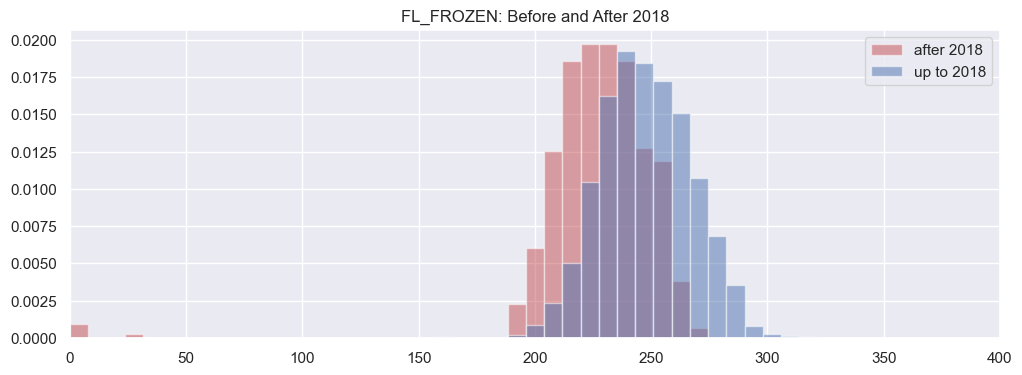

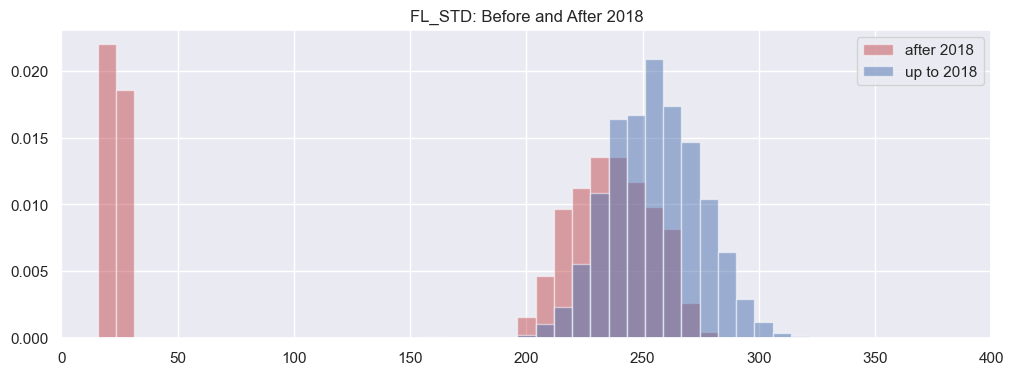

In [5]:
def hist_compare_years(year, feature, bins=50, xmin=0, xmax=400):
    
    plt.figure(figsize=(12,4))
    plt.xlim(xmin, xmax)
    
    bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)] 
    
    df_FD.loc[df_FD.DATETIME.dt.year > year, feature].hist(alpha=0.5, color=sns.color_palette()[3], density=True, label=f'after {year}', bins=bins_plot)
    df_FD.loc[df_FD.DATETIME.dt.year <= year, feature].hist(alpha=0.5, density=True, label=f'up to {year}', bins=bins_plot)
    
    plt.legend(loc='upper right')
    
    plt.title(feature.upper() + ': Before and After ' + str(year))
    plt.show()
    

# compare years and features
features_to_compare = ['FL_WET', 'FL_FROZEN', 'FL_STD']
years_to_compare = [2018]

for feature in features_to_compare:
    for year in years_to_compare:
        hist_compare_years(year, feature)

### FL_STD: null or scale - CONFIRM
* (264 entries)

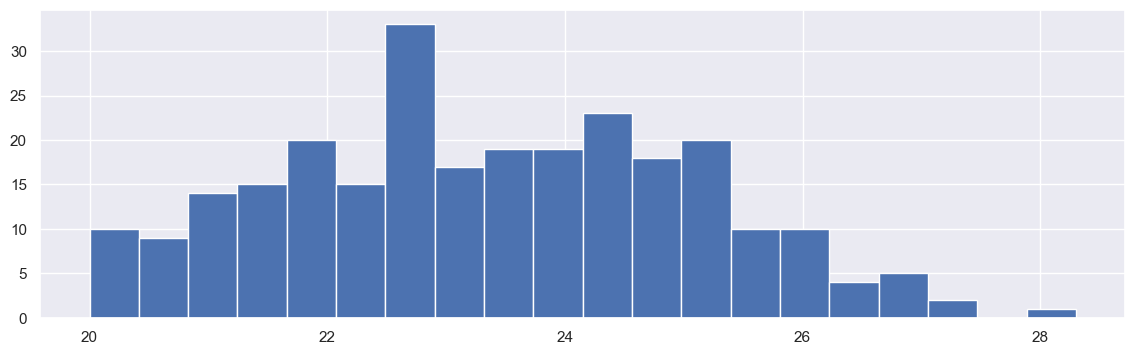

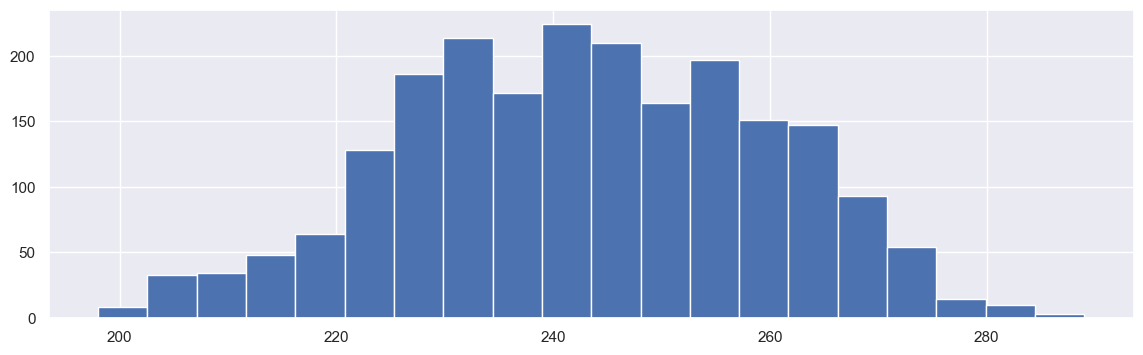

In [6]:
# looks like it's off by a multiple
df_FD[df_FD.FL_STD < 100].FL_STD.hist(figsize=(14,4), bins=20)
plt.show()

df_FD[(df_FD.YEAR > 2016) & (df_FD.YEAR < 2019)].FL_STD.hist(figsize=(14,4), bins=20)
plt.show()

In [7]:
confirm_FL_STD_null = True  # set to null
confirm_FL_STD_scale = False

# record indices of problems before transforming
index_FL_STD_problems = list(df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'].index)

if confirm_FL_STD_null:
    df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = np.nan
if confirm_FL_STD_scale:
    df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] = df_FD.loc[df_FD.FL_STD < 100, 'FL_STD'] * 10

### FL_WET and FL_FROZEN: null or scale - CONFIRM
* (5 entries)

In [8]:
# these also look like they are off by multiples

print('median FL_WET: ', df_FD.FL_WET.median())
print('median FL_FROZEN: ', df_FD.FL_FROZEN.median())

display(df_FD[(df_FD.FL_WET < 100) | (df_FD.FL_FROZEN < 100)][['FL_WET', 'FL_FROZEN']])

median FL_WET:  253.0
median FL_FROZEN:  247.0


,FL_WET,FL_FROZEN
35056,2,3
35141,28,28
35155,1,1
35156,2,3
35184,2,2


In [9]:
confirm_FL_WF_null = True  # set to null
confirm_FL_WF_scale = False

# NOTE: indices from Excel are 1 indexed, not 0 indexed, and row 1 is the header
# therefore, the indices are off by 2
idx_dict = {
    35058-2: 100,
    35143-2: 10,
    35157-2: 100,
    35158-2: 100,
    35186-2: 100
}

# split these into variables to improve readability
indices = idx_dict.keys()
scale_factors = [idx_dict[k] for k in idx_dict.keys()]

if confirm_FL_WF_null:
    df_FD.loc[indices, 'FL_WET'] = np.nan
    df_FD.loc[indices, 'FL_FROZEN'] = np.nan
if confirm_FL_WF_scale:
    df_FD.loc[indices, 'FL_WET'] = df_FD.loc[indices, 'FL_WET'] * scale_factors
    df_FD.loc[indices, 'FL_FROZEN'] = df_FD.loc[indices, 'FL_FROZEN'] * scale_factors

### how many FL_ but not FL_STD exist?

In [10]:
TEMP = df_FD[df_FD.FL_STD.isnull() & (df_FD.FL_WET.notna() | df_FD.FL_FROZEN.notna())][['DATETIME', 'FL_WET', 'FL_FROZEN', 'FL_STD']]
print(TEMP.shape[0], 'entries\n')
print(rand_samp := 10, 'random samples:')
display(TEMP.sample(rand_samp))

164 entries

10 random samples:


,DATETIME,FL_WET,FL_FROZEN,FL_STD
32365,2016-06-16,<NA>,236,NaN
32417,2016-06-29,<NA>,225,NaN
32422,2016-06-29,<NA>,256,NaN
32287,2016-06-09,<NA>,244,NaN
32416,2016-06-29,<NA>,210,NaN
32360,2016-06-16,<NA>,232,NaN
32395,2016-06-24,<NA>,220,NaN
32428,2016-06-29,<NA>,239,NaN
32308,2016-06-09,<NA>,228,NaN
32414,2016-06-29,<NA>,225,NaN


In [11]:
# they are all frozen but haven't been standardized
# what is the ratio, FROZEN to STD
TEMP = df_FD[df_FD.FL_STD.notna() & df_FD.FL_FROZEN.notna()]
(TEMP.FL_STD / TEMP.FL_FROZEN).describe()

count   25326.000
mean        1.033
std         0.002
min         1.026
25%         1.031
50%         1.032
75%         1.034
max         1.054
dtype: float64

### impute FL_STD from FL_FROZEN * factor - CONFIRM

In [12]:
idx = list(df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna(), 'FL_STD'].index)

In [13]:
impute_fl = True
factor = 1.033  # confirm

if impute_fl:
    df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna(), 'FL_STD'] = 1.033 * df_FD.loc[df_FD.FL_STD.isnull() & df_FD.FL_FROZEN.notna(), 'FL_FROZEN']
    df_FD['FL_STD'] = df_FD['FL_STD'] // 1
    df_FD['FL_STD'] = df_FD['FL_STD'].astype('Int64')

### SEX: leave or null 'U' - CONFIRM
NOTE: there are 749 'U' in 1987 (way more than all other years combined (797))
##### IRRELEVANT: either way will be imported into dm_apps as unknown (sex_id = 9)

In [14]:
confirm_SEX_U_null = False

if confirm_SEX_U_null:
     df_FD.loc[df_FD.SEX == 'U', 'SEX'] = np.nan

### SEX: leave or null 'B' - CONFIRM
* (only 1 entry)
* confirm B is not 'both' (if so, could change label to 'H' for hermaphrodite)

In [15]:
confirm_SEX_B_null = False

if confirm_SEX_B_null:
    df_FD.loc[df_FD.SEX == 'B', 'SEX'] = np.nan
        
confirm_SEX_B_actually_H = False

if confirm_SEX_B_actually_H:
    df_FD.loc[df_FD.SEX == 'B', 'SEX'] = 'H'

### MATURITY: leave or null '44' - CONFIRM
* (only 1 entry)
* could also be typo for 4

In [16]:
confirm_MATURITY_44_null = True

if confirm_MATURITY_44_null:
     df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = np.nan
        
confirm_MATURITY_44_actually_4 = False

if confirm_MATURITY_44_null:
     df_FD.loc[df_FD.MATURITY == 44, 'MATURITY'] = 4

### WEIGHT: Nullify outliers - CONFIRM
* (6 entries)
* they all look real except 1934g fish which could be checked manually

In [17]:
max_weight = 500

df_FD.loc[df_FD.WEIGHT > max_weight]

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME
724,1984,5,1,<NA>,12,NaN,Frozen,30,<NA>,316,325,519.000,A,F,2,NaN,NaN,7,6,NaN,NaN,<NA>,<NA>,NaN,NaN,7,6,1984-05-01
735,1984,5,2,<NA>,12,NaN,Frozen,1,<NA>,316,325,539.000,A,F,2,NaN,NaN,8,4,NaN,NaN,<NA>,<NA>,NaN,NaN,8,4,1984-05-02
956,1984,5,8,<NA>,12,NaN,Frozen,27,<NA>,310,319,501.000,A,F,2,NaN,NaN,8,3,NaN,NaN,<NA>,<NA>,NaN,NaN,8,3,1984-05-08
2042,1985,5,16,<NA>,12,NaN,Frozen,5,<NA>,317,326,512.000,A,F,2,83.000,NaN,9,3,NaN,NaN,<NA>,<NA>,NaN,NaN,9,3,1985-05-16
6917,1989,5,13,<NA>,35,PM,Frozen,23,<NA>,305,314,503.000,A,F,4,95.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1989-05-13
35019,2019,6,11,7,41,PM,Frozen,1,<NA>,<NA>,<NA>,1934.000,A,M,4,NaN,JM,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,2019-06-11


In [18]:
confirm_WEIGHT_null = False 

if confirm_WEIGHT_null:
     df_FD.loc[df_FD.WEIGHT > max_weight, 'WEIGHT'] = np.nan
        
# DEAL WITH 1934g FISH MANUALLY
df_FD.loc[df_FD.WEIGHT > 1900, 'WEIGHT'] = np.nan

### GONAD_WEIGHT: Nullify outliers - CONFIRM
* (7 entries)

In [19]:
max_gonad_weight = 200

df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight]

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME
6285,1989,5,16,<NA>,38,PM,Frozen,41,<NA>,270,278,283.000,A,F,4,417.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1989-05-16
14131,1995,6,2,5,"41,35",AM,Frozen,7,<NA>,276,284,337.000,A,F,4,766.000,NaN,<NA>,<NA>,NaN,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,1995-06-02
23059,2008,5,20,4,26,AM,Frozen,14,<NA>,260,268,277.300,A,F,4,414.800,NaN,5,4,NaN,NaN,<NA>,<NA>,NaN,NaN,5,4,2008-05-20
23295,2008,6,4,6,5,AM,Fresh,24,240,<NA>,240,176.400,A,F,4,219.600,NaN,3,3,NaN,NaN,<NA>,<NA>,NaN,NaN,3,3,2008-06-04
24542,2010,5,5,2,41,PM,Frozen,30,<NA>,262,270,233.700,A,F,4,335.500,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,2010-05-05
26462,2011,6,4,5,41,AM,Fresh,32,255,<NA>,255,220.300,A,F,4,280.000,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,2011-06-04
33026,2017,6,14,7,25,AM,Frozen,14,<NA>,246,254,183.400,B,F,4,256.000,JM,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,5,3,2017-06-14


In [20]:
confirm_GONAD_null = True  # all of these have gonads that weight more than the total weight

if confirm_GONAD_null:
     df_FD.loc[df_FD.GONAD_WEIGHT > max_gonad_weight, 'GONAD_WEIGHT'] = np.nan

### Validate weight to length ratio - CONFIRM

##### need to flag these and manually deal with them individually 


[4:25 PM] Fishman, David
would be based on length in cm and weight in g

<img style="float: left;" src=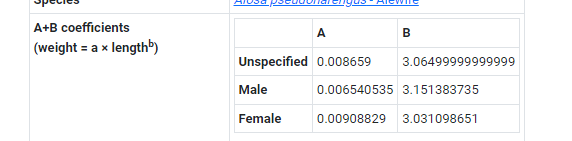>

In [21]:
def lw_prediction_delta(sex, length_mm, weight_g):
    """
    returns actual weight / predicted weight, based on length and sex
    """
    
    sex, length_mm, weight_g = str(sex), float(length_mm), float(weight_g)
    
    if sex.lower()[0] == 'm':
        A, B = 0.00654, 3.15
    elif sex.lower()[0] == 'f':
        A, B = 0.00909, 3.03
    else:
        A, B = 0.00866, 3.06
        
    # in grams, length converted mm to cm
    predicted_weight_g = A * ((length_mm / 10) ** B)
    
    return weight_g / predicted_weight_g


In [22]:
df_FD.head()

,YEAR,MM,DD,WEEK,SITE,PERIOD,CONDITION,FISH_NO,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,1st Person Aging,AGE,FSP,Comments,2nd Person Aging,AGE.1,FSP.1,Comments.1,Envelop Comments,AGE_notes,FSP_notes,DATETIME
0,1983,5,9,<NA>,12,NaN,Fresh,1,285,<NA>,285,336.000,A,F,2,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1983-05-09
1,1983,5,9,<NA>,12,NaN,Fresh,2,288,<NA>,288,334.000,A,F,2,NaN,NaN,5,3,NaN,NaN,<NA>,<NA>,NaN,NaN,5,3,1983-05-09
2,1983,5,9,<NA>,12,NaN,Fresh,3,280,<NA>,280,364.000,A,F,2,NaN,NaN,4,4,NaN,NaN,<NA>,<NA>,NaN,NaN,4,4,1983-05-09
3,1983,5,9,<NA>,12,NaN,Fresh,4,286,<NA>,286,353.000,A,F,2,NaN,NaN,4,3,NaN,NaN,<NA>,<NA>,NaN,NaN,4,3,1983-05-09
4,1983,5,9,<NA>,12,NaN,Fresh,5,297,<NA>,297,370.000,A,F,2,NaN,NaN,6,4,NaN,NaN,<NA>,<NA>,NaN,NaN,6,4,1983-05-09


In [23]:
# check the length width ratio outliers
df_FD['lw_ratio_check'] = 0.0

for i, row in df_FD.iterrows():
    try:
        df_FD.loc[i, 'lw_ratio_check'] = lw_prediction_delta(row['SEX'], row['FL_STD'], row['WEIGHT'])
    except TypeError:
        df_FD.loc[i, 'lw_ratio_check'] = np.nan
        

# number of samples with extraordinary dimensions
avg_ratio = df_FD['lw_ratio_check'].describe()['mean']
stdev = df_FD['lw_ratio_check'].describe()['std']

# how many standard deviations out should we examine?
n_stdev = 4
# with 3 stdev, there are 114 outliers to check

lw_ratio_min, lw_ratio_max = avg_ratio - n_stdev*stdev, avg_ratio + n_stdev*stdev
df_FD[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max)].shape

(34, 29)

In [24]:
# these are our outliers
columns = ['CONDITION', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 'GONAD_WEIGHT', 'AGE', 'lw_ratio_check']
df_FD[(df_FD['lw_ratio_check'] < lw_ratio_min) | (df_FD['lw_ratio_check'] > lw_ratio_max)].sort_values('lw_ratio_check')[columns]

,CONDITION,FL_WET,FL_FROZEN,FL_STD,WEIGHT,SPECIES,SEX,MATURITY,GONAD_WEIGHT,AGE,lw_ratio_check
25517,Frozen,<NA>,283,292,33.300,A,F,4,61.600,6,0.133
21685,Frozen,<NA>,205,212,15.100,B,M,4,NaN,<NA>,0.153
22400,Frozen,<NA>,366,376,170.900,A,F,4,23.500,3,0.317
32158,Fresh,358,<NA>,358,178.800,A,F,4,20.200,4,0.385
25952,Frozen,<NA>,299,308,150.900,A,M,4,NaN,3,0.472
26280,Fresh,299,<NA>,299,146.100,A,M,4,NaN,3,0.502
27587,Frozen,<NA>,244,252,93.700,B,M,4,NaN,4,0.552
29991,Frozen,<NA>,241,249,103.600,B,M,3,NaN,3,0.634
224,Fresh,257,<NA>,257,337.000,A,M,2,NaN,3,1.865
31074,Frozen,<NA>,225,233,235.900,A,F,3,30.500,5,1.867


### CONFIRM: whether any rows should be nulled/dropped/fixed

In [25]:
# drop the lw_ratio_check before saving
df_FD = df_FD.drop('lw_ratio_check', axis=1)

# LENGTH FREQUENCIES

In [26]:
df_LF = pd.read_csv(r'.\provided data\Margaree Gaspereau lgth-freq_Master.csv')

### Clean Date/Time and create DATETIME column

In [27]:
# convert all times to same format, set missing times to 0000 (date only), then to datetime format
df_LF['CleanTime'] = df_LF['Time']
df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] = df_LF.loc[df_LF['CleanTime'] < 10, 'CleanTime'] * 100
df_LF['CleanTime'] = pd.to_datetime(df_LF.CleanTime, format='%H%M')

# all null times should be 0000 (which pandas reads as no time data)
df_LF.loc[df_LF['CleanTime'].isnull(), 'CleanTime'] = pd.to_datetime(0)  

df_LF['DATETIME'] = pd.to_datetime(dict(
    year=df_LF['yy'], 
    month=df_LF['mm'], 
    day=df_LF['dd'], 
    hour=df_LF['CleanTime'].dt.hour, 
    minute=df_LF['CleanTime'].dt.minute
), errors='coerce')

df_LF = df_LF.drop('CleanTime', axis=1)

### Clean River Column

In [28]:
df_LF.loc[df_LF.river == 'SW Margaree', 'river'] = 'SW MARGAREE'
df_LF.river.unique()

array([nan, 'MARGAREE', 'SW MARGAREE'], dtype=object)

### Expand and Clean Site Column
* Later analysis shows matching with samples on the first noted site is more effective than combining multiple sites. 
* Consider adding extra sites to notes column or adding the ability to select multiple sites when inputting a sample.

In [29]:
df_LF[['SITE1', 'SITE2', 'SITE3']] = df_LF.site.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

### Clean Location

In [30]:
# clean the typos
df_LF.loc[df_LF['loc'] == 'LOWER ', 'loc'] = 'LOWER'
df_LF.loc[df_LF['loc'] == 'LOWE', 'loc'] = 'LOWER'
df_LF['loc'].unique()

array(['LOWER', 'UPPER', nan], dtype=object)

### Period: AD left as is - CONFIRM

In [31]:
df_LF.period.unique()

array(['PM', 'AM', 'AD'], dtype=object)

In [32]:
# counts: AM, PM, and AD
# AD data are also included in the FISH DETAILS, assumed not a typo (although rare)
sum(df_LF.period == 'AM'), sum(df_LF.period == 'PM'), sum(df_LF.period == 'AD')

(6143, 5250, 47)

# SAMPLES (logbook)

In [33]:
dtypes = {
    'code': 'object',
    'no_nets': 'object',
    'YEAR': 'Int32',
    'MM': 'Int32',
    'DD': 'Int32',
    'Week': 'Int32',
#     'hours_fished': 'Int32'  # some entries say 'maximum '
}
df_SD = pd.read_csv(r'.\provided data\Margaree Gaspereau logbooks_Master.csv', dtype=dtypes)

### replace hours_fished = 'maximum' with a number of hours - CONFIRM

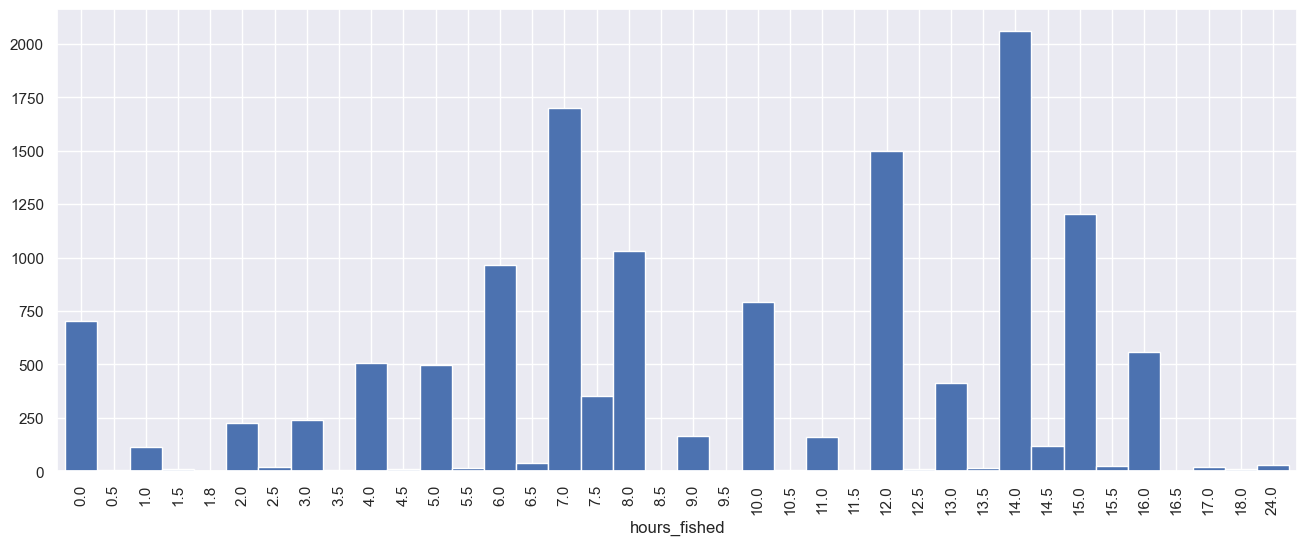

In [34]:
(
    df_SD.groupby('hours_fished')
    .count()
    .reset_index()
    .replace({'maximum ': 24})[['hours_fished', 'DIST']]
    .astype(float)
    .sort_values('hours_fished')
    .plot(kind='bar', x='hours_fished', y='DIST', width=1, figsize=(16, 6), legend=False)
);

In [35]:
# CONFIRM 24 is the correct time
# will import better if it is numeric formatting
numeric_hours_fished = True

if numeric_hours_fished:
    df_SD.loc[df_SD.hours_fished == 'maximum ', 'hours_fished'] = 24  # max could be 18
    df_SD['hours_fished'] = pd.to_numeric(df_SD['hours_fished'], errors='coerce').astype(float)

### NAME column
Create Samplers Table / Clean Sampler Names - CONFIRM

In [36]:
# SHOULD ANY OF THESE BE SUBSTITUTED / SPELLING CORRECTED?

sorted([str(x) for x in df_SD.NAME.unique()])

['Alexander Gillis',
 'Alexander MacDonald',
 'Allan B Gillis',
 'Anthony Cameron',
 'Brian Doyle',
 'Brian MacFarlane',
 'Bruce MacLellan',
 'Bruce McLellan',
 'Catherine MacFarlane',
 'Catherine MacLeod',
 'Charles McDaniel',
 'Chris MacLean',
 'Colin Gillis',
 'Daniel Stewart',
 'Darlene Cameron',
 'David MacKinnon',
 'Donald D Gillis',
 'Donald J Gillis',
 'Donald M Campbell',
 'Donald MacEachern',
 'Donald MacLeod',
 'Donald Macleod',
 'Donelda M Gillis',
 'Eleanor MacLellan',
 'Eleanor McDaniel',
 'Elizabeth MacKinnon',
 'Elizabeth/Vincent MacKinnon',
 'Finley MacDonald',
 'Finley Stewart',
 'Florence Gillis',
 'Fred Ingram',
 'Gerard MacFarlane',
 'Gerard V Chiasson',
 'Harold MacFarlane',
 'Hugh J Gillis',
 'Hughie MacDonnell',
 'Irene MacIsaac',
 'Jack MacLellan',
 'James A Hirtle',
 'James MacFarlane',
 'Jim Coady',
 'Jim MacFarlane',
 'Joan Ingram',
 'John A Chisholm',
 'John A Coady',
 'John Coady',
 'John H Gillis',
 'John MacLellan',
 'John Neil Gillis',
 'John R Gillis',

In [37]:
# Clean NAME column manually - CONFIRM
sampler_replacements = {
#     'Bruce MacLellan': 'Bruce McLellan',                     # CONFIRM
#     'Elizabeth/Vincent MacKinnon': 'Elizabeth MacKinnon',    # CONFIRM
    'Kevin MacKinnon ': 'Kevin MacKinnon',
    'Donald Macleod': 'Donald MacLeod'
}

# clean the name column
df_SD = df_SD.replace({'NAME': sampler_replacements})

In [38]:
# create samplers table

gaspereau_samplers = list()

for i in sorted(str(x) for x in df_SD.NAME.unique()):
    name = i.rsplit(maxsplit=1)  # put initials into first name
    gaspereau_samplers.append(name)
    
gaspereau_samplers = pd.DataFrame(gaspereau_samplers, columns=['first_name', 'last_name'])
gaspereau_samplers['notes'] = pd.NA  # all null comments

### Sites

In [39]:
# create columns for multiple sites
df_SD[['SITE1', 'SITE2']] = df_SD.SITE_NO.str.split(',', expand=True).fillna(pd.NA)

### DATETIME
* confirm leave null when missing days/months

In [40]:
df_SD['DATETIME'] = pd.to_datetime(
    df_SD['YEAR'].astype(str) + '-' + df_SD['MM'].astype(str) + '-' + df_SD['DD'].astype(str), 
    errors='coerce'  # coerce missing days and months into errors
)
# NOTE: these coerced errors do not affect the lookup ID for importing:
    # any entries with missing month or day will have NA filled with 0
    # ID is generated from YEAR, MM, and DD columns
sum(df_SD.DATETIME.isnull())

31

### clean zone

In [41]:
df_SD.loc[df_SD.zone == 'upper ', 'zone'] = 'upper'
df_SD.zone.unique()

array(['lower', 'upper', nan], dtype=object)

### clean bycatch / pre-generate 'remarks' before import - CONFIRM
* could also pregenerate notes/comments/remarks
    * add 'sbass' after int, concat if exists, etc
    * add extra sites to remarks?
    

### Note: Code for kwargs lookup in the import script used to combine remarks - it is cleaner in this notebook

        # remarks
        remarks = str()
        check_for_comments = ['COMMENTS', 'BYCATCH_SBASS', 'BYCATCH_SHAD', 'BYCATCH_OTHER']
        for column in check_for_comments:
            if row[column] and not row[column].isnumeric():  # if the row is non-blank, and not a string of a number
                remarks += (remarks != str()) * '; ' + row[column]  # add a semicolon between separate non-null comments
        kwargs['remarks'] = remarks

In [42]:
df_SD.bycatch_sbass.unique()

array([nan,  3.,  1.,  2.])

In [43]:
df_SD.bycatch_shad.unique()

array([nan,  1.])

In [44]:
df_SD.bycatch_other.unique()

array([nan, 'salmon', '1 perch, 1 speckled trou, 1 30 inch salmon',
       '1 lamprey eel (?)', '1', '2 trout', '1 trout', '5 lampreys',
       '1 baby lamprey', '4 trout, 3 "lamprey eels" (?)', '1 perch',
       '4 suckers', 'lamprey', '1 sucker'], dtype=object)

In [45]:
df_SD.comments.unique()

array([nan, 'striped bass were 23 inches',
       'river still high, fishing inside wing',
       'catch a salmon no marking 14 inch long', 'salted 4800 lbs',
       'salted 5000 lbs', 'outside wing in, river high',
       'salted 8000 lbs', '5 gaspereau', '26 gaspereau', 'did not fish',
       'Rainbow trout released', 'salmon', 'trout', 'salt', 'bait',
       'did not fish, returned logbook', 'wet snow', '6 fish',
       'heavy rain, flood', '3 fish', '10 fish', '1 fish', '8 fish',
       'heavy rain', 'did not fish on the 22nd. Water too high.'],
      dtype=object)

In [46]:
check_for_comments = ['comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other']

# update bycatch fields to text fields
df_SD.loc[df_SD['bycatch_sbass'].notna(), 'comment_sbass'] = 'bycatch_sbass: ' + df_SD[df_SD['bycatch_sbass'].notna()]['bycatch_sbass'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_shad'].notna(), 'comment_shad'] = 'bycatch_shad: ' + df_SD[df_SD['bycatch_shad'].notna()]['bycatch_shad'].astype(int).astype(str)
df_SD.loc[df_SD['bycatch_other'].notna(), 'comment_other'] = 'bycatch_other: ' + df_SD[df_SD['bycatch_other'].notna()]['bycatch_other']

# combine with semicolon to make remarks field
df_SD['remarks'] = df_SD[['comments', 'comment_sbass', 'comment_shad', 'comment_other']].apply(lambda x: '; '.join(x.dropna()), axis=1)

# set empty strings to NaN
df_SD.loc[df_SD.remarks == '', 'remarks'] = np.nan  

# drop extra bycatch string columns
df_SD = df_SD.drop(['comment_sbass', 'comment_shad', 'comment_other'], axis=1)

In [47]:
# check results
df_SD[df_SD.remarks.notna()].sample(5)

,DIST,RIVER,NAME,code,GEAR,SITE_NO,no_nets,YEAR,MM,DD,Week,catch_lbs,catch_kg,hours_fished,zone,last_name,comments,bycatch_sbass,bycatch_shad,bycatch_other,SITE1,SITE2,DATETIME,remarks
15017,2,SWMARG,Bruce MacLellan,NaN,81,51,1,2019,5,21,4,4.000,1.800,6.000,upper,MacLellan,10 fish,NaN,NaN,NaN,51,<NA>,2019-05-21,10 fish
14586,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2017,6,22,8,2700.000,1224.700,7.000,lower,Chiasson,NaN,3.000,NaN,NaN,26,<NA>,2017-06-22,bycatch_sbass: 3
15117,2,SWMARG,Mary E Gillis,NaN,81,49,1,2019,6,21,8,850.000,385.600,12.000,upper,Gillis,heavy rain,NaN,NaN,NaN,49,<NA>,2019-06-21,heavy rain
15180,2,SWMARG,Robert Peters,NaN,81,25,1,2019,5,30,5,1800.000,816.500,8.000,lower,Peters,NaN,1.000,NaN,NaN,25,<NA>,2019-05-30,bycatch_sbass: 1
14626,2,SWMARG,Pierre Chiasson,NaN,81,26,1,2018,5,10,2,200.000,90.700,7.000,lower,Chiasson,Rainbow trout released,NaN,NaN,1,26,<NA>,2018-05-10,Rainbow trout released; bycatch_other: 1


# ======================
# FORMATING FOR IMPORT
# ======================

* ALLCAPS: denotes columns that aren't perfect matches
* lowercase: denotes columns that should match perfectly with herring tables in dm_apps

# LENGTH FREQUENCIES
### Generate Unique IDs to Import / match with Samples

In [48]:
# replace non-numeric data with made up site numbers
# NOTE: These are converted back in import script
id_replacements = {
    '1A': 90,
    '1B': 91,
    'EricMcFarlane': 92,
    'JimmyMacFarlane': 93,
    'JohnAlbertCoady': 94
}
df_LF = df_LF.replace({'SITE1': id_replacements})

In [49]:
# 'unique' id column (note ambiguities, and solve later)
df_LF['id'] = (
    df_LF.DATETIME.dt.year*1_000_000 
    + df_LF.DATETIME.dt.month*10_000 
    + df_LF.DATETIME.dt.day*100 
    + df_LF.SITE1.fillna(0).astype(int)
).astype('Int64')

# new sample indicator
df_LF['new_sample'] = df_LF.lgth.diff() < 0

# new id indicator
df_LF['new_id'] = df_LF.id.diff() != 0

In [50]:
# update ids for ambiguous entries
duplicated_ids_LF = list(df_LF[~df_LF.new_id & df_LF.new_sample].id)

In [51]:
if df_LF.id.max() < 2_100_000_000: # only run this once

    # add 1B to duplicate ids
    df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] = df_LF.loc[df_LF.id.isin(duplicated_ids_LF), 'id'] + 1_000_000_000

    # add an extra billion to every other id, so that all are now distinct
    previous_lgth = 0
    multiplier = False

    for i, row in df_LF[df_LF.id > 2_900_000_000].iterrows():

        current_lgth = row['lgth']
        if previous_lgth > current_lgth:
            multiplier = not multiplier

        df_LF.loc[i, 'id'] = row.id + 1_000_000_000*multiplier

        previous_lgth = current_lgth

### Length Bins

In [52]:
# use the same bins as used in the herring database (cm, grouped by 0.5s)
df_LF['length_bin_id'] = (df_LF.lgth - df_LF.lgth % 5) / 10

### LENGTH FREQUENCY 
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [53]:
gaspereau_lengthfrequency = df_LF.groupby(['id', 'length_bin_id']).sum('freq').reset_index()[['freq', 'length_bin_id', 'id']].rename({
    'freq': 'count', 
    'length_bin_id': 'length_bin_id', 
    'id': 'sample_id'
}, axis=1)

# FISH DETAILS

In [54]:
# replace non-numeric data with made up site numbers
id_replacements_v2 = {
    '1A': 90,
    '1B': 91,
    'Eric MacFarlane': 92,
    'E.MACFARLANE': 92,
    'J McFarlane': 93,
    'JA Coady': 94,
    '11K3 (435,211)': 95, 
    '47 or 62': 47
}

# same site replacements from LF
df_FD['SITE1'] = df_FD.replace({'SITE': id_replacements_v2}).SITE
df_FD[['SITE1', 'SITE2', 'SITE3']] = df_FD.SITE1.str.replace(' ','').str.split(',', expand=True).fillna(pd.NA)

df_FD['sample_id'] = (
    df_FD.YEAR.astype(int)*1_000_000 
    + df_FD.MM.fillna(0).astype(int)*10_000
    + df_FD.DD.fillna(0).astype(int)*100
    + df_FD.SITE1.fillna(0).astype(int)
).astype('Int64')

### FISH DETAILS
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [55]:
# ALL CAPS used for unmatched fields
rename_FD = {
    'SITE1': 'SITE', 'FISH_NO': 'fish_number', 'FL_STD': 'fish_length', 
    'WEIGHT': 'fish_weight', 'MATURITY': 'maturity_id',
    'GONAD_WEIGHT': 'gonad_weight', '1st Person Aging': 'AGING_PERSON_1', 'AGE': 'AGE_1', 'FSP': 'FSP_1', 
    'Comments': 'AGE_COMMENTS_1', '2nd Person Aging': 'AGING_PERSON_2', 'AGE.1': 'AGE_2', 'FSP.1': 'FSP_2', 
    'Comments.1': 'AGE_COMMENTS_2', 'Envelop Comments': 'ENVELOP_COMMENTS', 'AGE_notes': 'AGE_NOTES', 'FSP_notes': 'FSP_NOTES'
}

gaspereau_fishdetails = df_FD[[
    'sample_id','DATETIME', 'SITE1',
    'CONDITION', 'FISH_NO', 'FL_WET', 'FL_FROZEN', 'FL_STD', 'WEIGHT', 'SPECIES', 'SEX', 'MATURITY', 
    'GONAD_WEIGHT', '1st Person Aging', 'AGE', 'FSP', 'Comments', '2nd Person Aging', 'AGE.1', 'FSP.1', 'Comments.1', 
    'Envelop Comments', 'AGE_notes', 'FSP_notes'
]].rename(columns=rename_FD)

# change SITE to int filetype
gaspereau_fishdetails['SITE'] = gaspereau_fishdetails['SITE'].astype('Int64')

# SAMPLES

In [56]:
# same site replacements from LF
df_SD = df_SD.replace({'SITE1': id_replacements})

# 'unique' id column
df_SD['id'] = (
    df_SD.YEAR.astype(int)*1_000_000 
    + df_SD.MM.fillna(0).astype(int)*10_000
    + df_SD.DD.fillna(0).astype(int)*100
    + df_SD.SITE1.fillna(0).astype(int)
).astype('Int64')

# duplicated ids
duplicated_ids_SD = set(df_SD[df_SD.duplicated('id', keep=False)].id)

In [57]:
# some of these ids end up with an extra digit
if df_SD.id.max() < 2_100_000_000:
    
    # initialise number of handled repeats as zero for each id
    n_repeats = dict(zip(duplicated_ids_SD, [0 for x in duplicated_ids_SD]))
    
    for i, row in df_SD[df_SD.id.isin(duplicated_ids_SD)].iterrows():
        df_SD.loc[i, 'id'] = row['id'] + 1_000_000_000 * int(n_repeats[row['id']] + 1)
        n_repeats[row['id']] += 1

### CONFIRM:  add null sample data where there is unmatched length frequencies and fish details
* if these null data are added, all fish detail and length frequencies should get into dm_apps
* if null data are not added, unmatched fish detail and length frequencies will be added to rejected files (csv generated on import)

In [58]:
# how many length frequency measurements are matched with samples?
# apprx 80%
(
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique(), 
    df_LF.id.nunique(), 
    df_LF[df_LF.id.isin(set(df_SD.id))].id.nunique() / df_LF.id.nunique()
)

(731, 917, 0.797164667393675)

In [59]:
# how many fish detail sample ids are matched with samples id column?
# apprx 83% (95% after correcting for LF missing - significant overlap)
(
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique(), 
    df_FD.sample_id.nunique(), 
    df_FD[df_FD.sample_id.isin(set(df_SD.id))].sample_id.nunique() / df_FD.sample_id.nunique()
)

(923, 1106, 0.8345388788426763)

In [60]:
# CONFIRM

add_null_data_where_unmatched = True

if add_null_data_where_unmatched:
    # add null samples where no match exists
    df_SD = pd.concat([df_SD, pd.DataFrame(df_LF[~df_LF.id.isin(set(df_SD.id))].id.unique(), columns=['id'])]).reset_index(drop=True)

    # NOTE: if a datetime column is useful in this null sample data, pd.to_datetime(id // 100) should work as a quick fix
    # alternatively, could use a more complicated JOIN to add SITE1 as well
    # leave this way for now

    df_SD = pd.concat([df_SD, pd.DataFrame(df_FD[~df_FD.sample_id.isin(set(df_SD.id))].sample_id.unique(), columns=['id'])]).reset_index(drop=True)
    # again, a few more details could be added, but leave for now because the sample data is incomplete either way

### SAMPLE DATA
### FINAL TABLE FOR IMPORT INTO DM_APPS

In [61]:
gaspereau_fishdetails.SITE.unique()

<IntegerArray>
[  12,    8,   17,   33,    5,    9,   25,    2,   64,   15,   49,   56, <NA>,
    7,   11,   35,   38,   39,   51,   37,   46,   48,   34,    4,   23,   67,
    1,   26,   28,    6,   52,   29,   60,   41,   27,   47,   14,   30,   62]
Length: 39, dtype: Int64

In [62]:
# ALL CAPS FOR UNMATCHED
rename_SD = {
    'DATETIME': 'sample_date', 'DIST': 'district_id', 'RIVER': 'fishing_area_id', 
    'NAME': 'SAMPLER', 'code': 'CODE', 'GEAR': 'gear_id', 'SITE1': 'SITE',
    'no_nets': 'NO_NETS', 'catch_lbs': 'catch_weight_lbs', 'hours_fished': 'HOURS_FISHED', 
    'zone': 'ZONE', 'last_name': 'LAST_NAME', 'comments': 'COMMENTS',
    'bycatch_sbass': 'BYCATCH_SBASS', 'bycatch_shad': 'BYCATCH_SHAD', 'bycatch_other': 'BYCATCH_OTHER', 
    'wt_lbs': 'sample_weight_lbs'
}

# JOIN with Length Frequency table to get sample weight
gaspereau_sample = pd.merge(
    df_SD[[
        'id', 'DATETIME', 'DIST', 'RIVER', 'NAME', 'code', 'GEAR', 'SITE1', 'no_nets', 'catch_lbs', 'hours_fished', 
        'zone', 'last_name', 'comments', 'bycatch_sbass', 'bycatch_shad', 'bycatch_other', 'remarks'
    ]], 
    df_LF[['id', 'wt_lbs']],
    on='id', 
    how='left'  # all samples 
).drop_duplicates().reset_index(drop=True).rename(columns=rename_SD)

# change SITE to int filetype
# gaspereau_sample['SITE'] = gaspereau_sample['SITE'].astype('Int64')  # I have no idea why this doesn't work
gaspereau_sample['SITE'] = gaspereau_sample['SITE'].fillna(0).astype(np.int64).replace({0: np.nan}).astype('Int64')  # I have no idea why this does work

# SAVE TABLES

In [63]:
# save pickle files
if True:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_pickle('gaspereau_lengthfrequency.pickle')
    gaspereau_fishdetails.to_pickle('gaspereau_fishdetails.pickle')
    gaspereau_sample.to_pickle('gaspereau_sample.pickle')
    gaspereau_samplers.to_pickle('gaspereau_samplers.pickle')
    
# save csv for import into django
if True:  # change this to overwrite/resave
    gaspereau_lengthfrequency.to_csv('gaspereau_lengthfrequency.csv')
    gaspereau_fishdetails.to_csv('gaspereau_fishdetails.csv')
    gaspereau_sample.to_csv('gaspereau_sample.csv')
    gaspereau_samplers.to_csv('gaspereau_samplers.csv')